In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from salishsea_tools import viz_tools, places,geo_tools, bloomdrivers as bd, evaltools as et
import xarray as xr
import datetime as dt
from scipy.stats import sem
import scipy.stats as stats


%matplotlib inline

### Load watermasks for pre- and post-September 2011 HRDPS grid

In [2]:
Watermask1 = xr.open_dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/GEM_watermask_for_gem_files_pre_22sep11.nc')
Watermask2 = xr.open_dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/GEM_watermask_for_gem_files_22sep11_onward.nc')

In [3]:
# get grid corners (use 2015, pre Sept 22, 2011 and post Sept 22 2011 files)

<class 'netCDF4._netCDF4.Variable'>
float32 u_wind(time_counter, y, x)
    _FillValue: nan
    level: 10 m above surface
    long_name: U-Component of Wind
    standard_name: x_wind
    units: m/s
    ioos_category: wind speed and direction
unlimited dimensions: time_counter
current shape = (24, 266, 256)
filling on


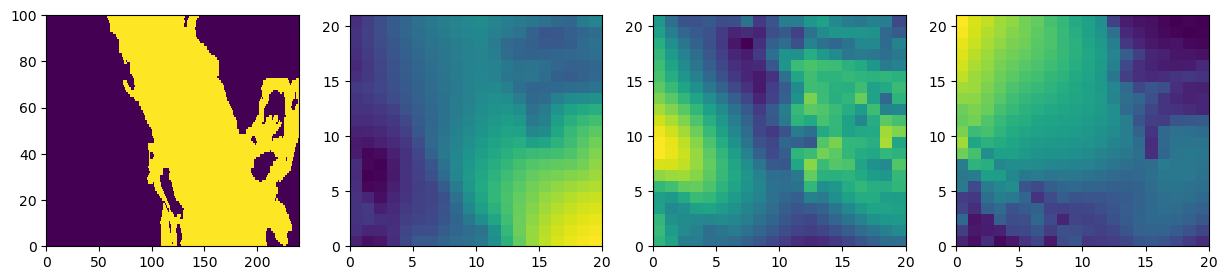

In [4]:
fig,ax=plt.subplots(1,4,figsize=(15,3))
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc') as mesh:
    navlon=mesh.variables['nav_lon'][:,:]
    navlat=mesh.variables['nav_lat'][:,:]
    tmask=mesh.variables['tmask'][0,:,:,:]
    ax[0].pcolormesh(mesh.variables['tmask'][0,0,450:550,110:350])
with nc.Dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2015m03d01.nc') as g:
    ops_lon=g.variables['nav_lon'][:,:]
    ops_lat=g.variables['nav_lat'][:,:]
    ax[1].pcolormesh((g.variables['u_wind'][0,119:140,143:163]**2+\
                      g.variables['v_wind'][0,119:140,143:163]**2)**(1/2))
    #.pcolormesh(g.variables[])
with nc.Dataset('/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2011m09d21.nc') as g: 
    gl1_lon=g.variables['nav_lon'][:,:]
    gl1_lat=g.variables['nav_lat'][:,:]
    ax[2].pcolormesh((g.variables['u_wind'][0,119:140,143:163]**2+\
                      g.variables['v_wind'][0,119:140,143:163]**2)**(1/2))
with nc.Dataset('/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2011m09d22.nc') as g: 
    gl2_lon=g.variables['nav_lon'][:,:]
    gl2_lat=g.variables['nav_lat'][:,:]
    ax[3].pcolormesh((g.variables['u_wind'][0,119:140,143:163]**2+\
                      g.variables['v_wind'][0,119:140,143:163]**2)**(1/2))
    print(g.variables['u_wind'])

In [5]:
ll_lon=navlon[450,110]
lr_lon=navlon[450,350]
ul_lon=navlon[550,110]
ur_lon=navlon[550,350]
ll_lat=navlat[450,110]
lr_lat=navlat[450,350]
ul_lat=navlat[550,110]
ur_lat=navlat[550,350]

In [6]:
(ll_j_ops,ll_i_ops)=geo_tools.find_closest_model_point(ll_lon,ll_lat,ops_lon-360,ops_lat,grid='GEM2.5')
(lr_j_ops,lr_i_ops)=geo_tools.find_closest_model_point(lr_lon,lr_lat,ops_lon-360,ops_lat,grid='GEM2.5')
(ul_j_ops,ul_i_ops)=geo_tools.find_closest_model_point(ul_lon,ul_lat,ops_lon-360,ops_lat,grid='GEM2.5')
(ur_j_ops,ur_i_ops)=geo_tools.find_closest_model_point(ur_lon,ur_lat,ops_lon-360,ops_lat,grid='GEM2.5')
print((ll_j_ops,ll_i_ops),(lr_j_ops,lr_i_ops),(ul_j_ops,ul_i_ops),(ur_j_ops,ur_i_ops))

(130, 118) (144, 160) (150, 111) (163, 153)


In [7]:
(ll_j_gl1,ll_i_gl1)=geo_tools.find_closest_model_point(ll_lon,ll_lat,gl1_lon-360,gl1_lat,grid='GEM2.5')
(lr_j_gl1,lr_i_gl1)=geo_tools.find_closest_model_point(lr_lon,lr_lat,gl1_lon-360,gl2_lat,grid='GEM2.5')
(ul_j_gl1,ul_i_gl1)=geo_tools.find_closest_model_point(ul_lon,ul_lat,gl1_lon-360,gl1_lat,grid='GEM2.5')
(ur_j_gl1,ur_i_gl1)=geo_tools.find_closest_model_point(ur_lon,ur_lat,gl1_lon-360,gl1_lat,grid='GEM2.5')
print((ll_j_gl1,ll_i_gl1),(lr_j_gl1,lr_i_gl1),(ul_j_gl1,ul_i_gl1),(ur_j_gl1,ur_i_gl1))

(123, 117) (141, 157) (142, 111) (156, 150)


In [8]:
(ll_j_gl2,ll_i_gl2)=geo_tools.find_closest_model_point(ll_lon,ll_lat,gl2_lon-360,gl2_lat,grid='GEM2.5')
(lr_j_gl2,lr_i_gl2)=geo_tools.find_closest_model_point(lr_lon,lr_lat,gl2_lon-360,gl2_lat,grid='GEM2.5')
(ul_j_gl2,ul_i_gl2)=geo_tools.find_closest_model_point(ul_lon,ul_lat,gl2_lon-360,gl2_lat,grid='GEM2.5')
(ur_j_gl2,ur_i_gl2)=geo_tools.find_closest_model_point(ur_lon,ur_lat,gl2_lon-360,gl2_lat,grid='GEM2.5')
print((ll_j_gl2,ll_i_gl2),(lr_j_gl2,lr_i_gl2),(ul_j_gl2,ul_i_gl2),(ur_j_gl2,ur_i_gl2))

(127, 121) (141, 160) (146, 114) (159, 153)


In [9]:
# ops: use j: 130:163, i: 111:160
# gl1: use j: 123:156, i: 111:157
# gl2: use j: 127:159, i: 114:160

In [10]:
def getWindVars(day):
    if day>dt.datetime(2014,12,1): #or day.year>2014
        opsdir='/results/forcing/atmospheric/GEM2.5/operational/'
        nam_fmt='ops'
        jlims=(130,163)
        ilims=(111,160)
    elif day<dt.datetime(2011,9,22):
        opsdir='/results/forcing/atmospheric/GEM2.5/gemlam'
        nam_fmt='gemlam'
        jlims=(123,156)
        ilims=(111,167)
    else:
        opsdir='/results/forcing/atmospheric/GEM2.5/gemlam'
        nam_fmt='gemlam'
        jlims=(127,159)
        ilims=(114,160)
    return opsdir, nam_fmt, jlims,ilims

/tmp/ipykernel_1189272/3000062760.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(navlon[350:850,100:398],navlat[350:850,100:398],tmask[0,350:850,100:398],shading='auto')


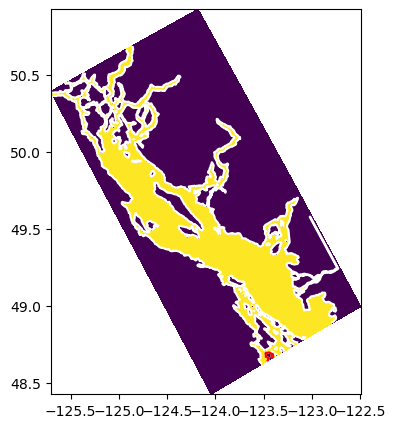

In [11]:
fig,ax=plt.subplots(1,1,figsize=(4,5))
ax.pcolormesh(navlon[350:850,100:398],navlat[350:850,100:398],tmask[0,350:850,100:398],shading='auto')
cl=ax.contour(navlon[350:850,100:398],navlat[350:850,100:398],tmask[0,350:850,100:398],[.5],colors='w')
plt.plot(cl.allsegs[0][0][:,0],cl.allsegs[0][0][:,1],'r-')

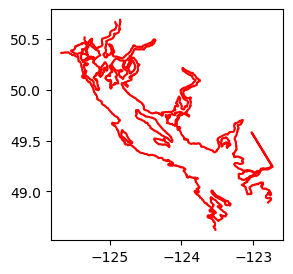

In [12]:
fig,ax=plt.subplots(1,1,figsize=(3,3))
lens=list()
modlines=list()
for ii in range(0,len(cl.allsegs[0])):
    lens.append(len(cl.allsegs[0][ii][:,1]))
    #if np.min(cl.allsegs[0][ii][:,1])<49.2 and np.max(cl.allsegs[0][ii][:,1])>50:
    if len(cl.allsegs[0][ii][:,1])>100:
        #print(ii)
        ax.plot(cl.allsegs[0][ii][:,0],cl.allsegs[0][ii][:,1],'r-')
        modlines.append((cl.allsegs[0][ii][:,0],cl.allsegs[0][ii][:,1]))

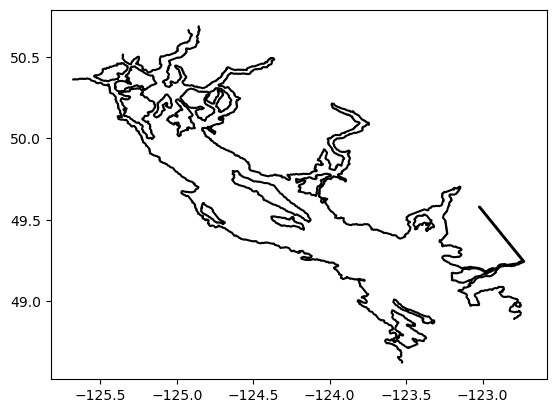

In [13]:
for (lons,lats) in modlines:
    plt.plot(lons,lats,'k-')

In [14]:
opslines=list()
for (lons,lats) in modlines:
    x=np.array([geo_tools.find_closest_model_point(lon,lat,ops_lon-360,ops_lat,grid='GEM2.5') \
                for lat, lon in zip(lats,lons)])
    opslines.append((x[:,0],x[:,1]))

In [15]:
gl1lines=list()
for (lons,lats) in modlines:
    x=np.array([geo_tools.find_closest_model_point(lon,lat,gl1_lon-360,gl1_lat,grid='GEM2.5') \
                for lat, lon in zip(lats,lons)])
    gl1lines.append((x[:,0],x[:,1]))

In [16]:
gl2lines=list()
for (lons,lats) in modlines:
    x=np.array([geo_tools.find_closest_model_point(lon,lat,gl2_lon-360,gl2_lat,grid='GEM2.5') \
                for lat, lon in zip(lats,lons)])
    gl2lines.append((x[:,0],x[:,1]))

In [17]:
# extract march mean wind from one of each type of file:
## ops, 2015
year=2015
day=dt.datetime(year,3,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,3,1),dt.datetime(year,3,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
U3ops=(fu**2+fv**2)**(1/2) ## use 3/2 to get wind speed cubed
U3opsmean=np.mean(U3ops,0)

## gl1, 2007
year=2007
day=dt.datetime(year,3,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,3,1),dt.datetime(year,3,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
U3gl1=(fu**2+fv**2)**(1/2)
U3gl1mean=np.mean(U3gl1,0)

## gl2, 2012
year=2012
day=dt.datetime(year,3,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,3,1),dt.datetime(year,3,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
U3gl2=(fu**2+fv**2)**(1/2)
U3gl2mean=np.mean(U3gl2,0)

## Test to make sure the land mask works

In [18]:
year=2008
day=dt.datetime(year,1,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,1,1),dt.datetime(year,1,2),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1]))for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
test=(fu**2+fv**2)**(1/2)
testmean=np.mean(test,0)

#
#.where(HRDPS.landmask)

In [19]:
test2008=np.nanmean(testmean)

In [20]:
fu.shape

(24, 33, 56)

In [21]:
fs[0]['u_wind'].shape

(24, 266, 256)

In [22]:
Watermask1.mask.shape

(266, 256)

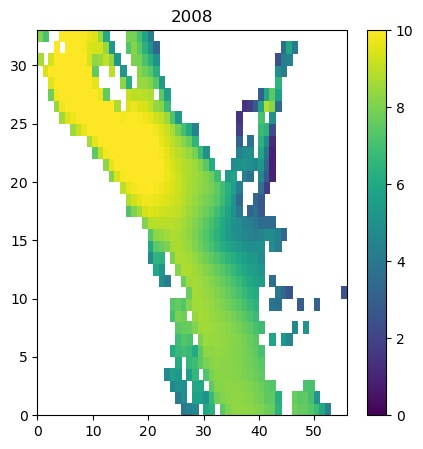

In [23]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
vmin=0
vmax=10

iax=ax
iax.set_title('2008')
m=iax.pcolormesh(testmean,vmin=vmin, vmax=vmax)
fig.colorbar(m,ax=iax)
#for (jj,ii) in gl1lines:
#    iax.plot(ii-96,jj-114,'r-')

## January

In [24]:
# extract march mean wind from one of each type of file:

## gl1, 2007
#year=2007
#day=dt.datetime(year,1,1)
#opsdir, namfmt, jlims, ilims = getWindVars(day)
#flist=et.index_model_files(dt.datetime(year,1,1),dt.datetime(year,1,31),opsdir,namfmt,
#                           flen=1,ftype='None',tres=24);
#fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
#fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
#fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
#gl12007=(fu**2+fv**2)**(3/2)
#margl12007mean=np.mean(gl12007,0)

## gl1, 2008
year=2008
day=dt.datetime(year,1,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,1,1),dt.datetime(year,1,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jan_gl12008=(fu**2+fv**2)**(1/2)
jan_gl12008mean=np.mean(jan_gl12008,0)

## gl1, 2007
year=2009
day=dt.datetime(year,1,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,1,1),dt.datetime(year,1,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jan_gl12009=(fu**2+fv**2)**(1/2)
jan_gl12009mean=np.mean(jan_gl12009,0)

## gl1, 2007
year=2010
day=dt.datetime(year,1,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,1,1),dt.datetime(year,1,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jan_gl12010=(fu**2+fv**2)**(1/2)
jan_gl12010mean=np.mean(jan_gl12010,0)

## gl1, 2007
year=2011
day=dt.datetime(year,1,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,1,1),dt.datetime(year,1,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jan_gl12011=(fu**2+fv**2)**(1/2)
jan_gl12011mean=np.mean(jan_gl12011,0)

## gl1, 2007
year=2012
day=dt.datetime(year,1,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,1,1),dt.datetime(year,1,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jan_gl22012=(fu**2+fv**2)**(1/2)
jan_gl22012mean=np.mean(jan_gl22012,0)

## gl1, 2007
year=2013
day=dt.datetime(year,1,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,1,1),dt.datetime(year,1,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jan_gl22013=(fu**2+fv**2)**(1/2)
jan_gl22013mean=np.mean(jan_gl22013,0)

## gl1, 2007
year=2014
day=dt.datetime(year,1,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,1,1),dt.datetime(year,1,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jan_gl22014=(fu**2+fv**2)**(1/2)
jan_gl22014mean=np.mean(jan_gl22014,0)

## gl1, 2007
year=2015
day=dt.datetime(year,1,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,1,1),dt.datetime(year,1,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jan_ops2015=(fu**2+fv**2)**(1/2)
jan_ops2015mean=np.mean(jan_ops2015,0)

## ops, 2015
year=2016
day=dt.datetime(year,1,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,1,1),dt.datetime(year,1,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jan_ops2016=(fu**2+fv**2)**(1/2)
jan_ops2016mean=np.mean(jan_ops2016,0)

## gl1, 2007
year=2017
day=dt.datetime(year,1,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,1,1),dt.datetime(year,1,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jan_ops2017=(fu**2+fv**2)**(1/2)
jan_ops2017mean=np.mean(jan_ops2017,0)

## gl1, 2007
year=2018
day=dt.datetime(year,1,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,1,1),dt.datetime(year,1,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jan_ops2018=(fu**2+fv**2)**(1/2)
jan_ops2018mean=np.mean(jan_ops2018,0)

## gl1, 2007
year=2019
day=dt.datetime(year,1,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,1,1),dt.datetime(year,1,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jan_ops2019=(fu**2+fv**2)**(1/2)
jan_ops2019mean=np.mean(jan_ops2019,0)

## gl1, 2007
year=2020
day=dt.datetime(year,1,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,1,1),dt.datetime(year,1,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jan_ops2020=(fu**2+fv**2)**(1/2)
jan_ops2020mean=np.mean(jan_ops2020,0)

In [25]:
jan_ops2020mean

<xarray.DataArray (y: 33, x: 49)>
dask.array<mean_agg-aggregate, shape=(33, 49), dtype=float32, chunksize=(33, 49), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 2.775e+05 2.8e+05 2.825e+05 ... 3.95e+05 3.975e+05
  * y        (y) float64 3.25e+05 3.275e+05 3.3e+05 ... 4e+05 4.025e+05 4.05e+05

In [26]:
#Jan2007=np.nanmean(jan_gl12007mean)
Jan2008=np.nanmean(jan_gl12008mean)
Jan2009=np.nanmean(jan_gl12009mean)
Jan2010=np.nanmean(jan_gl12010mean)
Jan2011=np.nanmean(jan_gl12011mean)
Jan2012=np.nanmean(jan_gl22012mean)
Jan2013=np.nanmean(jan_gl22013mean)
Jan2014=np.nanmean(jan_gl22014mean)
Jan2015=np.nanmean(jan_ops2015mean)
Jan2016=np.nanmean(jan_ops2016mean)
Jan2017=np.nanmean(jan_ops2017mean)
Jan2018=np.nanmean(jan_ops2018mean)
Jan2019=np.nanmean(jan_ops2019mean)
Jan2020=np.nanmean(jan_ops2020mean)

## February

In [27]:
# extract feb mean wind from one of each type of file:

year=2007
day=dt.datetime(year,2,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,2,1),dt.datetime(year,2,28),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
feb_gl12007=(fu**2+fv**2)**(1/2)
feb_gl12007mean=np.mean(feb_gl12007,0)


year=2008
day=dt.datetime(year,2,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,2,1),dt.datetime(year,2,29),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
feb_gl12008=(fu**2+fv**2)**(1/2)
feb_gl12008mean=np.mean(feb_gl12008,0)


year=2009
day=dt.datetime(year,2,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,2,1),dt.datetime(year,2,28),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
feb_gl12009=(fu**2+fv**2)**(1/2)
feb_gl12009mean=np.mean(feb_gl12009,0)


year=2010
day=dt.datetime(year,2,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,2,1),dt.datetime(year,2,28),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
feb_gl12010=(fu**2+fv**2)**(1/2)
feb_gl12010mean=np.mean(feb_gl12010,0)


year=2011
day=dt.datetime(year,2,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,2,1),dt.datetime(year,2,28),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
feb_gl12011=(fu**2+fv**2)**(1/2)
feb_gl12011mean=np.mean(feb_gl12011,0)


year=2012
day=dt.datetime(year,2,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,2,1),dt.datetime(year,2,29),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
feb_gl22012=(fu**2+fv**2)**(1/2)
feb_gl22012mean=np.mean(feb_gl22012,0)


year=2013
day=dt.datetime(year,2,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,2,1),dt.datetime(year,2,28),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
feb_gl22013=(fu**2+fv**2)**(1/2)
feb_gl22013mean=np.mean(feb_gl22013,0)


year=2014
day=dt.datetime(year,2,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,2,1),dt.datetime(year,2,28),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
feb_gl22014=(fu**2+fv**2)**(1/2)
feb_gl22014mean=np.mean(feb_gl22014,0)


year=2015
day=dt.datetime(year,2,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,2,1),dt.datetime(year,2,28),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
feb_ops2015=(fu**2+fv**2)**(1/2)
feb_ops2015mean=np.mean(feb_ops2015,0)


year=2016
day=dt.datetime(year,2,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,2,1),dt.datetime(year,2,29),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
feb_ops2016=(fu**2+fv**2)**(1/2)
feb_ops2016mean=np.mean(feb_ops2016,0)


year=2017
day=dt.datetime(year,2,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,2,1),dt.datetime(year,2,28),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
feb_ops2017=(fu**2+fv**2)**(1/2)
feb_ops2017mean=np.mean(feb_ops2017,0)


year=2018
day=dt.datetime(year,2,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,2,1),dt.datetime(year,2,28),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
feb_ops2018=(fu**2+fv**2)**(1/2)
feb_ops2018mean=np.mean(feb_ops2018,0)


year=2019
day=dt.datetime(year,2,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,2,1),dt.datetime(year,2,28),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
feb_ops2019=(fu**2+fv**2)**(1/2)
feb_ops2019mean=np.mean(feb_ops2019,0)


year=2020
day=dt.datetime(year,2,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,2,1),dt.datetime(year,2,29),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
feb_ops2020=(fu**2+fv**2)**(1/2)
feb_ops2020mean=np.mean(feb_ops2020,0)

In [28]:
Feb2007=np.nanmean(feb_gl12007mean)
Feb2008=np.nanmean(feb_gl12008mean)
Feb2009=np.nanmean(feb_gl12009mean)
Feb2010=np.nanmean(feb_gl12010mean)
Feb2011=np.nanmean(feb_gl12011mean)
Feb2012=np.nanmean(feb_gl22012mean)
Feb2013=np.nanmean(feb_gl22013mean)
Feb2014=np.nanmean(feb_gl22014mean)
Feb2015=np.nanmean(feb_ops2015mean)
Feb2016=np.nanmean(feb_ops2016mean)
Feb2017=np.nanmean(feb_ops2017mean)
Feb2018=np.nanmean(feb_ops2018mean)
Feb2019=np.nanmean(feb_ops2019mean)
Feb2020=np.nanmean(feb_ops2020mean)

## March

In [29]:
# extract march mean wind from one of each type of file:

## gl1, 2007
year=2007
day=dt.datetime(year,3,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,3,1),dt.datetime(year,3,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
mar_gl12007=(fu**2+fv**2)**(1/2)
mar_gl12007mean=np.mean(mar_gl12007,0)

## gl1, 2008
year=2008
day=dt.datetime(year,3,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,3,1),dt.datetime(year,3,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
mar_gl12008=(fu**2+fv**2)**(1/2)
mar_gl12008mean=np.mean(mar_gl12008,0)

## gl1, 2007
year=2009
day=dt.datetime(year,3,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,3,1),dt.datetime(year,3,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
mar_gl12009=(fu**2+fv**2)**(1/2)
mar_gl12009mean=np.mean(mar_gl12009,0)

## gl1, 2007
year=2010
day=dt.datetime(year,3,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,3,1),dt.datetime(year,3,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
mar_gl12010=(fu**2+fv**2)**(1/2)
mar_gl12010mean=np.mean(mar_gl12010,0)

## gl1, 2007
year=2011
day=dt.datetime(year,3,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,3,1),dt.datetime(year,3,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
mar_gl12011=(fu**2+fv**2)**(1/2)
mar_gl12011mean=np.mean(mar_gl12011,0)

## gl1, 2007
year=2012
day=dt.datetime(year,3,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,3,1),dt.datetime(year,3,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
mar_gl22012=(fu**2+fv**2)**(1/2)
mar_gl22012mean=np.mean(mar_gl22012,0)

## gl1, 2007
year=2013
day=dt.datetime(year,3,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,3,1),dt.datetime(year,3,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
mar_gl22013=(fu**2+fv**2)**(1/2)
mar_gl22013mean=np.mean(mar_gl22013,0)

## gl1, 2007
year=2014
day=dt.datetime(year,3,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,3,1),dt.datetime(year,3,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
mar_gl22014=(fu**2+fv**2)**(1/2)
mar_gl22014mean=np.mean(mar_gl22014,0)

## gl1, 2007
year=2015
day=dt.datetime(year,3,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,3,1),dt.datetime(year,3,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
mar_ops2015=(fu**2+fv**2)**(1/2)
mar_ops2015mean=np.mean(mar_ops2015,0)

## ops, 2015
year=2016
day=dt.datetime(year,3,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,3,1),dt.datetime(year,3,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
mar_ops2016=(fu**2+fv**2)**(1/2)
mar_ops2016mean=np.mean(mar_ops2016,0)

## gl1, 2007
year=2017
day=dt.datetime(year,3,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,3,1),dt.datetime(year,3,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
mar_ops2017=(fu**2+fv**2)**(1/2)
mar_ops2017mean=np.mean(mar_ops2017,0)

## gl1, 2007
year=2018
day=dt.datetime(year,3,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,3,1),dt.datetime(year,3,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
mar_ops2018=(fu**2+fv**2)**(1/2)
mar_ops2018mean=np.mean(mar_ops2018,0)

## gl1, 2007
year=2019
day=dt.datetime(year,3,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,3,1),dt.datetime(year,3,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
mar_ops2019=(fu**2+fv**2)**(1/2)
mar_ops2019mean=np.mean(mar_ops2019,0)

## gl1, 2007
year=2020
day=dt.datetime(year,3,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,3,1),dt.datetime(year,3,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
mar_ops2020=(fu**2+fv**2)**(1/2)
mar_ops2020mean=np.mean(mar_ops2020,0)


In [30]:
Mar2007=np.nanmean(mar_gl12007mean)
Mar2008=np.nanmean(mar_gl12008mean)
Mar2009=np.nanmean(mar_gl12009mean)
Mar2010=np.nanmean(mar_gl12010mean)
Mar2011=np.nanmean(mar_gl12011mean)
Mar2012=np.nanmean(mar_gl22012mean)
Mar2013=np.nanmean(mar_gl22013mean)
Mar2014=np.nanmean(mar_gl22014mean)
Mar2015=np.nanmean(mar_ops2015mean)
Mar2016=np.nanmean(mar_ops2016mean)
Mar2017=np.nanmean(mar_ops2017mean)
Mar2018=np.nanmean(mar_ops2018mean)
Mar2019=np.nanmean(mar_ops2019mean)
Mar2020=np.nanmean(mar_ops2020mean)

## April

In [31]:
# extract feb mean wind from one of each type of file:

year=2007
day=dt.datetime(year,4,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,4,1),dt.datetime(year,4,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
apr_gl12007=(fu**2+fv**2)**(1/2)
apr_gl12007mean=np.mean(apr_gl12007,0)


year=2008
day=dt.datetime(year,4,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,4,1),dt.datetime(year,4,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
apr_gl12008=(fu**2+fv**2)**(1/2)
apr_gl12008mean=np.mean(apr_gl12008,0)


year=2009
day=dt.datetime(year,4,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,4,1),dt.datetime(year,4,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
apr_gl12009=(fu**2+fv**2)**(1/2)
apr_gl12009mean=np.mean(apr_gl12009,0)


year=2010
day=dt.datetime(year,4,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,4,1),dt.datetime(year,4,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
apr_gl12010=(fu**2+fv**2)**(1/2)
apr_gl12010mean=np.mean(apr_gl12010,0)


year=2011
day=dt.datetime(year,4,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,4,1),dt.datetime(year,4,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
apr_gl12011=(fu**2+fv**2)**(1/2)
apr_gl12011mean=np.mean(apr_gl12011,0)


year=2012
day=dt.datetime(year,4,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,4,1),dt.datetime(year,4,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
apr_gl22012=(fu**2+fv**2)**(1/2)
apr_gl22012mean=np.mean(apr_gl22012,0)


year=2013
day=dt.datetime(year,4,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,4,1),dt.datetime(year,4,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
apr_gl22013=(fu**2+fv**2)**(1/2)
apr_gl22013mean=np.mean(apr_gl22013,0)


year=2014
day=dt.datetime(year,4,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,4,1),dt.datetime(year,4,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
apr_gl22014=(fu**2+fv**2)**(1/2)
apr_gl22014mean=np.mean(apr_gl22014,0)


year=2015
day=dt.datetime(year,4,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,4,1),dt.datetime(year,4,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
apr_ops2015=(fu**2+fv**2)**(1/2)
apr_ops2015mean=np.mean(apr_ops2015,0)


year=2016
day=dt.datetime(year,4,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,4,1),dt.datetime(year,4,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
apr_ops2016=(fu**2+fv**2)**(1/2)
apr_ops2016mean=np.mean(apr_ops2016,0)


year=2017
day=dt.datetime(year,4,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,4,1),dt.datetime(year,4,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
apr_ops2017=(fu**2+fv**2)**(1/2)
apr_ops2017mean=np.mean(apr_ops2017,0)


year=2018
day=dt.datetime(year,4,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,4,1),dt.datetime(year,4,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
apr_ops2018=(fu**2+fv**2)**(1/2)
apr_ops2018mean=np.mean(apr_ops2018,0)


year=2019
day=dt.datetime(year,4,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,4,1),dt.datetime(year,4,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
apr_ops2019=(fu**2+fv**2)**(1/2)
apr_ops2019mean=np.mean(apr_ops2019,0)


year=2020
day=dt.datetime(year,4,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,4,1),dt.datetime(year,4,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
apr_ops2020=(fu**2+fv**2)**(1/2)
apr_ops2020mean=np.mean(apr_ops2020,0)

In [32]:
Apr2007=np.nanmean(apr_gl12007mean)
Apr2008=np.nanmean(apr_gl12008mean)
Apr2009=np.nanmean(apr_gl12009mean)
Apr2010=np.nanmean(apr_gl12010mean)
Apr2011=np.nanmean(apr_gl12011mean)
Apr2012=np.nanmean(apr_gl22012mean)
Apr2013=np.nanmean(apr_gl22013mean)
Apr2014=np.nanmean(apr_gl22014mean)
Apr2015=np.nanmean(apr_ops2015mean)
Apr2016=np.nanmean(apr_ops2016mean)
Apr2017=np.nanmean(apr_ops2017mean)
Apr2018=np.nanmean(apr_ops2018mean)
Apr2019=np.nanmean(apr_ops2019mean)
Apr2020=np.nanmean(apr_ops2020mean)

## May

In [33]:
# extract feb mean wind from one of each type of file:

year=2007
day=dt.datetime(year,5,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,5,1),dt.datetime(year,5,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
may_gl12007=(fu**2+fv**2)**(1/2)
may_gl12007mean=np.mean(may_gl12007,0)


year=2008
day=dt.datetime(year,5,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,5,1),dt.datetime(year,5,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
may_gl12008=(fu**2+fv**2)**(1/2)
may_gl12008mean=np.mean(may_gl12008,0)


year=2009
day=dt.datetime(year,5,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,5,1),dt.datetime(year,5,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
may_gl12009=(fu**2+fv**2)**(1/2)
may_gl12009mean=np.mean(may_gl12009,0)


year=2010
day=dt.datetime(year,5,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,5,1),dt.datetime(year,5,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
may_gl12010=(fu**2+fv**2)**(1/2)
may_gl12010mean=np.mean(may_gl12010,0)


year=2011
day=dt.datetime(year,5,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,5,1),dt.datetime(year,5,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
may_gl12011=(fu**2+fv**2)**(1/2)
may_gl12011mean=np.mean(may_gl12011,0)


year=2012
day=dt.datetime(year,5,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,5,1),dt.datetime(year,5,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
may_gl22012=(fu**2+fv**2)**(1/2)
may_gl22012mean=np.mean(may_gl22012,0)


year=2013
day=dt.datetime(year,5,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,5,1),dt.datetime(year,5,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
may_gl22013=(fu**2+fv**2)**(1/2)
may_gl22013mean=np.mean(may_gl22013,0)


year=2014
day=dt.datetime(year,5,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,5,1),dt.datetime(year,5,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
may_gl22014=(fu**2+fv**2)**(1/2)
may_gl22014mean=np.mean(may_gl22014,0)


year=2015
day=dt.datetime(year,5,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,5,1),dt.datetime(year,5,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
may_ops2015=(fu**2+fv**2)**(1/2)
may_ops2015mean=np.mean(may_ops2015,0)


year=2016
day=dt.datetime(year,5,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,5,1),dt.datetime(year,5,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
may_ops2016=(fu**2+fv**2)**(1/2)
may_ops2016mean=np.mean(may_ops2016,0)


year=2017
day=dt.datetime(year,5,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,5,1),dt.datetime(year,5,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
may_ops2017=(fu**2+fv**2)**(1/2)
may_ops2017mean=np.mean(may_ops2017,0)


year=2018
day=dt.datetime(year,5,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,5,1),dt.datetime(year,5,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
may_ops2018=(fu**2+fv**2)**(1/2)
may_ops2018mean=np.mean(may_ops2018,0)


year=2019
day=dt.datetime(year,5,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,5,1),dt.datetime(year,5,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
may_ops2019=(fu**2+fv**2)**(1/2)
may_ops2019mean=np.mean(may_ops2019,0)


year=2020
day=dt.datetime(year,5,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,5,1),dt.datetime(year,5,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
may_ops2020=(fu**2+fv**2)**(1/2)
may_ops2020mean=np.mean(may_ops2020,0)

In [34]:
May2007=np.nanmean(may_gl12007mean)
May2008=np.nanmean(may_gl12008mean)
May2009=np.nanmean(may_gl12009mean)
May2010=np.nanmean(may_gl12010mean)
May2011=np.nanmean(may_gl12011mean)
May2012=np.nanmean(may_gl22012mean)
May2013=np.nanmean(may_gl22013mean)
May2014=np.nanmean(may_gl22014mean)
May2015=np.nanmean(may_ops2015mean)
May2016=np.nanmean(may_ops2016mean)
May2017=np.nanmean(may_ops2017mean)
May2018=np.nanmean(may_ops2018mean)
May2019=np.nanmean(may_ops2019mean)
May2020=np.nanmean(may_ops2020mean)

## June

In [35]:
# extract feb mean wind from one of each type of file:

year=2007
day=dt.datetime(year,6,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,6,1),dt.datetime(year,6,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jun_gl12007=(fu**2+fv**2)**(1/2)
jun_gl12007mean=np.mean(jun_gl12007,0)


year=2008
day=dt.datetime(year,6,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,6,1),dt.datetime(year,6,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jun_gl12008=(fu**2+fv**2)**(1/2)
jun_gl12008mean=np.mean(jun_gl12008,0)


year=2009
day=dt.datetime(year,6,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,6,1),dt.datetime(year,6,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jun_gl12009=(fu**2+fv**2)**(1/2)
jun_gl12009mean=np.mean(jun_gl12009,0)


year=2010
day=dt.datetime(year,6,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,6,1),dt.datetime(year,6,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jun_gl12010=(fu**2+fv**2)**(1/2)
jun_gl12010mean=np.mean(jun_gl12010,0)


year=2011
day=dt.datetime(year,6,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,6,1),dt.datetime(year,6,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jun_gl12011=(fu**2+fv**2)**(1/2)
jun_gl12011mean=np.mean(jun_gl12011,0)


year=2012
day=dt.datetime(year,6,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,6,1),dt.datetime(year,6,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jun_gl22012=(fu**2+fv**2)**(1/2)
jun_gl22012mean=np.mean(jun_gl22012,0)


year=2013
day=dt.datetime(year,6,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,6,1),dt.datetime(year,6,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jun_gl22013=(fu**2+fv**2)**(1/2)
jun_gl22013mean=np.mean(jun_gl22013,0)


year=2014
day=dt.datetime(year,6,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,6,1),dt.datetime(year,6,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jun_gl22014=(fu**2+fv**2)**(1/2)
jun_gl22014mean=np.mean(jun_gl22014,0)


year=2015
day=dt.datetime(year,6,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,6,1),dt.datetime(year,6,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jun_ops2015=(fu**2+fv**2)**(1/2)
jun_ops2015mean=np.mean(jun_ops2015,0)


year=2016
day=dt.datetime(year,6,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,6,1),dt.datetime(year,6,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jun_ops2016=(fu**2+fv**2)**(1/2)
jun_ops2016mean=np.mean(jun_ops2016,0)


year=2017
day=dt.datetime(year,6,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,6,1),dt.datetime(year,6,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jun_ops2017=(fu**2+fv**2)**(1/2)
jun_ops2017mean=np.mean(jun_ops2017,0)


year=2018
day=dt.datetime(year,6,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,6,1),dt.datetime(year,6,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jun_ops2018=(fu**2+fv**2)**(1/2)
jun_ops2018mean=np.mean(jun_ops2018,0)


year=2019
day=dt.datetime(year,6,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,6,1),dt.datetime(year,6,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jun_ops2019=(fu**2+fv**2)**(1/2)
jun_ops2019mean=np.mean(jun_ops2019,0)


year=2020
day=dt.datetime(year,6,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,6,1),dt.datetime(year,6,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jun_ops2020=(fu**2+fv**2)**(1/2)
jun_ops2020mean=np.mean(jun_ops2020,0)

In [36]:
Jun2007=np.nanmean(jun_gl12007mean)
Jun2008=np.nanmean(jun_gl12008mean)
Jun2009=np.nanmean(jun_gl12009mean)
Jun2010=np.nanmean(jun_gl12010mean)
Jun2011=np.nanmean(jun_gl12011mean)
Jun2012=np.nanmean(jun_gl22012mean)
Jun2013=np.nanmean(jun_gl22013mean)
Jun2014=np.nanmean(jun_gl22014mean)
Jun2015=np.nanmean(jun_ops2015mean)
Jun2016=np.nanmean(jun_ops2016mean)
Jun2017=np.nanmean(jun_ops2017mean)
Jun2018=np.nanmean(jun_ops2018mean)
Jun2019=np.nanmean(jun_ops2019mean)
Jun2020=np.nanmean(jun_ops2020mean)

## July

In [37]:
# extract feb mean wind from one of each type of file:

year=2007
day=dt.datetime(year,7,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,7,1),dt.datetime(year,7,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jul_gl12007=(fu**2+fv**2)**(1/2)
jul_gl12007mean=np.mean(jul_gl12007,0)


year=2008
day=dt.datetime(year,7,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,7,1),dt.datetime(year,7,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jul_gl12008=(fu**2+fv**2)**(1/2)
jul_gl12008mean=np.mean(jul_gl12008,0)


year=2009
day=dt.datetime(year,7,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,7,1),dt.datetime(year,7,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jul_gl12009=(fu**2+fv**2)**(1/2)
jul_gl12009mean=np.mean(jul_gl12009,0)


year=2010
day=dt.datetime(year,7,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,7,1),dt.datetime(year,7,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jul_gl12010=(fu**2+fv**2)**(1/2)
jul_gl12010mean=np.mean(jul_gl12010,0)


year=2011
day=dt.datetime(year,7,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,7,1),dt.datetime(year,7,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jul_gl12011=(fu**2+fv**2)**(1/2)
jul_gl12011mean=np.mean(jul_gl12011,0)


year=2012
day=dt.datetime(year,7,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,7,1),dt.datetime(year,7,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jul_gl22012=(fu**2+fv**2)**(1/2)
jul_gl22012mean=np.mean(jul_gl22012,0)


year=2013
day=dt.datetime(year,7,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,7,1),dt.datetime(year,7,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jul_gl22013=(fu**2+fv**2)**(1/2)
jul_gl22013mean=np.mean(jul_gl22013,0)


year=2014
day=dt.datetime(year,7,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,7,1),dt.datetime(year,7,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jul_gl22014=(fu**2+fv**2)**(1/2)
jul_gl22014mean=np.mean(jul_gl22014,0)


year=2015
day=dt.datetime(year,7,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,7,1),dt.datetime(year,7,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jul_ops2015=(fu**2+fv**2)**(1/2)
jul_ops2015mean=np.mean(jul_ops2015,0)


year=2016
day=dt.datetime(year,7,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,7,1),dt.datetime(year,7,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jul_ops2016=(fu**2+fv**2)**(1/2)
jul_ops2016mean=np.mean(jul_ops2016,0)


year=2017
day=dt.datetime(year,7,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,7,1),dt.datetime(year,7,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jul_ops2017=(fu**2+fv**2)**(1/2)
jul_ops2017mean=np.mean(jul_ops2017,0)


year=2018
day=dt.datetime(year,7,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,7,1),dt.datetime(year,7,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jul_ops2018=(fu**2+fv**2)**(1/2)
jul_ops2018mean=np.mean(jul_ops2018,0)


year=2019
day=dt.datetime(year,7,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,7,1),dt.datetime(year,7,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jul_ops2019=(fu**2+fv**2)**(1/2)
jul_ops2019mean=np.mean(jul_ops2019,0)


year=2020
day=dt.datetime(year,7,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,7,1),dt.datetime(year,7,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
jul_ops2020=(fu**2+fv**2)**(1/2)
jul_ops2020mean=np.mean(jul_ops2020,0)

In [38]:
Jul2007=np.nanmean(jul_gl12007mean)
Jul2008=np.nanmean(jul_gl12008mean)
Jul2009=np.nanmean(jul_gl12009mean)
Jul2010=np.nanmean(jul_gl12010mean)
Jul2011=np.nanmean(jul_gl12011mean)
Jul2012=np.nanmean(jul_gl22012mean)
Jul2013=np.nanmean(jul_gl22013mean)
Jul2014=np.nanmean(jul_gl22014mean)
Jul2015=np.nanmean(jul_ops2015mean)
Jul2016=np.nanmean(jul_ops2016mean)
Jul2017=np.nanmean(jul_ops2017mean)
Jul2018=np.nanmean(jul_ops2018mean)
Jul2019=np.nanmean(jul_ops2019mean)
Jul2020=np.nanmean(jul_ops2020mean)

## August

In [39]:
# extract feb mean wind from one of each type of file:

year=2007
day=dt.datetime(year,8,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,8,1),dt.datetime(year,8,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
aug_gl12007=(fu**2+fv**2)**(1/2)
aug_gl12007mean=np.mean(aug_gl12007,0)


year=2008
day=dt.datetime(year,8,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,8,1),dt.datetime(year,8,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
aug_gl12008=(fu**2+fv**2)**(1/2)
aug_gl12008mean=np.mean(aug_gl12008,0)


year=2009
day=dt.datetime(year,8,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,8,1),dt.datetime(year,8,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
aug_gl12009=(fu**2+fv**2)**(1/2)
aug_gl12009mean=np.mean(aug_gl12009,0)


year=2010
day=dt.datetime(year,8,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,8,1),dt.datetime(year,8,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
aug_gl12010=(fu**2+fv**2)**(1/2)
aug_gl12010mean=np.mean(aug_gl12010,0)


year=2011
day=dt.datetime(year,8,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,8,1),dt.datetime(year,8,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
aug_gl12011=(fu**2+fv**2)**(1/2)
aug_gl12011mean=np.mean(aug_gl12011,0)


year=2012
day=dt.datetime(year,8,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,8,1),dt.datetime(year,8,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
aug_gl22012=(fu**2+fv**2)**(1/2)
aug_gl22012mean=np.mean(aug_gl22012,0)


year=2013
day=dt.datetime(year,8,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,8,1),dt.datetime(year,8,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
aug_gl22013=(fu**2+fv**2)**(1/2)
aug_gl22013mean=np.mean(aug_gl22013,0)


year=2014
day=dt.datetime(year,8,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,8,1),dt.datetime(year,8,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
aug_gl22014=(fu**2+fv**2)**(1/2)
aug_gl22014mean=np.mean(aug_gl22014,0)


year=2015
day=dt.datetime(year,8,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,8,1),dt.datetime(year,8,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
aug_ops2015=(fu**2+fv**2)**(1/2)
aug_ops2015mean=np.mean(aug_ops2015,0)


year=2016
day=dt.datetime(year,8,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,8,1),dt.datetime(year,8,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
aug_ops2016=(fu**2+fv**2)**(1/2)
aug_ops2016mean=np.mean(aug_ops2016,0)


year=2017
day=dt.datetime(year,8,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,8,1),dt.datetime(year,8,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
aug_ops2017=(fu**2+fv**2)**(1/2)
aug_ops2017mean=np.mean(aug_ops2017,0)


year=2018
day=dt.datetime(year,8,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,8,1),dt.datetime(year,8,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
aug_ops2018=(fu**2+fv**2)**(1/2)
aug_ops2018mean=np.mean(aug_ops2018,0)


year=2019
day=dt.datetime(year,8,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,8,1),dt.datetime(year,8,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
aug_ops2019=(fu**2+fv**2)**(1/2)
aug_ops2019mean=np.mean(aug_ops2019,0)


year=2020
day=dt.datetime(year,8,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,8,1),dt.datetime(year,8,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
aug_ops2020=(fu**2+fv**2)**(1/2)
aug_ops2020mean=np.mean(aug_ops2020,0)

In [40]:
Aug2007=np.nanmean(aug_gl12007mean)
Aug2008=np.nanmean(aug_gl12008mean)
Aug2009=np.nanmean(aug_gl12009mean)
Aug2010=np.nanmean(aug_gl12010mean)
Aug2011=np.nanmean(aug_gl12011mean)
Aug2012=np.nanmean(aug_gl22012mean)
Aug2013=np.nanmean(aug_gl22013mean)
Aug2014=np.nanmean(aug_gl22014mean)
Aug2015=np.nanmean(aug_ops2015mean)
Aug2016=np.nanmean(aug_ops2016mean)
Aug2017=np.nanmean(aug_ops2017mean)
Aug2018=np.nanmean(aug_ops2018mean)
Aug2019=np.nanmean(aug_ops2019mean)
Aug2020=np.nanmean(aug_ops2020mean)

## September

In [41]:
# extract feb mean wind from one of each type of file:

year=2007
day=dt.datetime(year,9,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,9,1),dt.datetime(year,9,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
sep_gl12007=(fu**2+fv**2)**(1/2)
sep_gl12007mean=np.mean(sep_gl12007,0)


year=2008
day=dt.datetime(year,9,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,9,1),dt.datetime(year,9,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
sep_gl12008=(fu**2+fv**2)**(1/2)
sep_gl12008mean=np.mean(sep_gl12008,0)


year=2009
day=dt.datetime(year,9,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,9,1),dt.datetime(year,9,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
sep_gl12009=(fu**2+fv**2)**(1/2)
sep_gl12009mean=np.mean(sep_gl12009,0)


year=2010
day=dt.datetime(year,9,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,9,1),dt.datetime(year,9,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
sep_gl12010=(fu**2+fv**2)**(1/2)
sep_gl12010mean=np.mean(sep_gl12010,0)


year=2011
day=dt.datetime(year,9,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,9,1),dt.datetime(year,9,22),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
sep_gl12011=(fu**2+fv**2)**(1/2)
sep_gl12011mean=np.mean(sep_gl12011,0)


year=2012
day=dt.datetime(year,9,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,9,1),dt.datetime(year,9,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
sep_gl22012=(fu**2+fv**2)**(1/2)
sep_gl22012mean=np.mean(sep_gl22012,0)


year=2013
day=dt.datetime(year,9,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,9,1),dt.datetime(year,9,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
sep_gl22013=(fu**2+fv**2)**(1/2)
sep_gl22013mean=np.mean(sep_gl22013,0)


year=2014
day=dt.datetime(year,9,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,9,1),dt.datetime(year,9,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
sep_gl22014=(fu**2+fv**2)**(1/2)
sep_gl22014mean=np.mean(sep_gl22014,0)


year=2015
day=dt.datetime(year,9,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,9,1),dt.datetime(year,9,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
sep_ops2015=(fu**2+fv**2)**(1/2)
sep_ops2015mean=np.mean(sep_ops2015,0)


year=2016
day=dt.datetime(year,9,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,9,1),dt.datetime(year,9,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
sep_ops2016=(fu**2+fv**2)**(1/2)
sep_ops2016mean=np.mean(sep_ops2016,0)


year=2017
day=dt.datetime(year,9,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,9,1),dt.datetime(year,9,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
sep_ops2017=(fu**2+fv**2)**(1/2)
sep_ops2017mean=np.mean(sep_ops2017,0)


year=2018
day=dt.datetime(year,9,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,9,1),dt.datetime(year,9,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
sep_ops2018=(fu**2+fv**2)**(1/2)
sep_ops2018mean=np.mean(sep_ops2018,0)


year=2019
day=dt.datetime(year,9,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,9,1),dt.datetime(year,9,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
sep_ops2019=(fu**2+fv**2)**(1/2)
sep_ops2019mean=np.mean(sep_ops2019,0)


year=2020
day=dt.datetime(year,9,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,9,1),dt.datetime(year,9,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
sep_ops2020=(fu**2+fv**2)**(1/2)
sep_ops2020mean=np.mean(sep_ops2020,0)

In [42]:
Sep2007=np.nanmean(sep_gl12007mean)
Sep2008=np.nanmean(sep_gl12008mean)
Sep2009=np.nanmean(sep_gl12009mean)
Sep2010=np.nanmean(sep_gl12010mean)
Sep2011=np.nanmean(sep_gl12011mean)
Sep2012=np.nanmean(sep_gl22012mean)
Sep2013=np.nanmean(sep_gl22013mean)
Sep2014=np.nanmean(sep_gl22014mean)
Sep2015=np.nanmean(sep_ops2015mean)
Sep2016=np.nanmean(sep_ops2016mean)
Sep2017=np.nanmean(sep_ops2017mean)
Sep2018=np.nanmean(sep_ops2018mean)
Sep2019=np.nanmean(sep_ops2019mean)
Sep2020=np.nanmean(sep_ops2020mean)

## October

In [43]:
# extract feb mean wind from one of each type of file:

year=2007
day=dt.datetime(year,10,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,10,1),dt.datetime(year,10,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
oct_gl12007=(fu**2+fv**2)**(1/2)
oct_gl12007mean=np.mean(oct_gl12007,0)


year=2008
day=dt.datetime(year,10,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,10,1),dt.datetime(year,10,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
oct_gl12008=(fu**2+fv**2)**(1/2)
oct_gl12008mean=np.mean(oct_gl12008,0)


year=2009
day=dt.datetime(year,10,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,10,1),dt.datetime(year,10,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
oct_gl12009=(fu**2+fv**2)**(1/2)
oct_gl12009mean=np.mean(oct_gl12009,0)


year=2010
day=dt.datetime(year,10,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,10,1),dt.datetime(year,10,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
oct_gl12010=(fu**2+fv**2)**(1/2)
oct_gl12010mean=np.mean(oct_gl12010,0)


year=2011
day=dt.datetime(year,10,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,10,1),dt.datetime(year,10,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
oct_gl12011=(fu**2+fv**2)**(1/2)
oct_gl12011mean=np.mean(oct_gl12011,0)


year=2012
day=dt.datetime(year,10,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,10,1),dt.datetime(year,10,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
oct_gl22012=(fu**2+fv**2)**(1/2)
oct_gl22012mean=np.mean(oct_gl22012,0)


year=2013
day=dt.datetime(year,10,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,10,1),dt.datetime(year,10,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
oct_gl22013=(fu**2+fv**2)**(1/2)
oct_gl22013mean=np.mean(oct_gl22013,0)


year=2014
day=dt.datetime(year,10,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,10,1),dt.datetime(year,10,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
oct_gl22014=(fu**2+fv**2)**(1/2)
oct_gl22014mean=np.mean(oct_gl22014,0)


year=2015
day=dt.datetime(year,10,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,10,1),dt.datetime(year,10,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
oct_ops2015=(fu**2+fv**2)**(1/2)
oct_ops2015mean=np.mean(oct_ops2015,0)


year=2016
day=dt.datetime(year,10,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,10,1),dt.datetime(year,10,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
oct_ops2016=(fu**2+fv**2)**(1/2)
oct_ops2016mean=np.mean(oct_ops2016,0)


year=2017
day=dt.datetime(year,10,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,10,1),dt.datetime(year,10,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
oct_ops2017=(fu**2+fv**2)**(1/2)
oct_ops2017mean=np.mean(oct_ops2017,0)


year=2018
day=dt.datetime(year,10,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,10,1),dt.datetime(year,10,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
oct_ops2018=(fu**2+fv**2)**(1/2)
oct_ops2018mean=np.mean(oct_ops2018,0)


year=2019
day=dt.datetime(year,10,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,10,1),dt.datetime(year,10,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
oct_ops2019=(fu**2+fv**2)**(1/2)
oct_ops2019mean=np.mean(oct_ops2019,0)


year=2020
day=dt.datetime(year,10,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,10,1),dt.datetime(year,10,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
oct_ops2020=(fu**2+fv**2)**(1/2)
oct_ops2020mean=np.mean(oct_ops2020,0)

In [44]:
Oct2007=np.nanmean(oct_gl12007mean)
Oct2008=np.nanmean(oct_gl12008mean)
Oct2009=np.nanmean(oct_gl12009mean)
Oct2010=np.nanmean(oct_gl12010mean)
Oct2011=np.nanmean(oct_gl12011mean)
Oct2012=np.nanmean(oct_gl22012mean)
Oct2013=np.nanmean(oct_gl22013mean)
Oct2014=np.nanmean(oct_gl22014mean)
Oct2015=np.nanmean(oct_ops2015mean)
Oct2016=np.nanmean(oct_ops2016mean)
Oct2017=np.nanmean(oct_ops2017mean)
Oct2018=np.nanmean(oct_ops2018mean)
Oct2019=np.nanmean(oct_ops2019mean)
Oct2020=np.nanmean(oct_ops2020mean)

## November

In [45]:
# extract feb mean wind from one of each type of file:

year=2007
day=dt.datetime(year,11,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,11,1),dt.datetime(year,11,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
nov_gl12007=(fu**2+fv**2)**(1/2)
nov_gl12007mean=np.mean(nov_gl12007,0)


year=2008
day=dt.datetime(year,11,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,11,1),dt.datetime(year,11,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
nov_gl12008=(fu**2+fv**2)**(1/2)
nov_gl12008mean=np.mean(nov_gl12008,0)


year=2009
day=dt.datetime(year,11,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,11,1),dt.datetime(year,11,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
nov_gl12009=(fu**2+fv**2)**(1/2)
nov_gl12009mean=np.mean(nov_gl12009,0)


year=2010
day=dt.datetime(year,11,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,11,1),dt.datetime(year,11,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
nov_gl12010=(fu**2+fv**2)**(1/2)
nov_gl12010mean=np.mean(nov_gl12010,0)


year=2011
day=dt.datetime(year,11,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,11,1),dt.datetime(year,11,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
nov_gl12011=(fu**2+fv**2)**(1/2)
nov_gl12011mean=np.mean(nov_gl12011,0)


year=2012
day=dt.datetime(year,11,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,11,1),dt.datetime(year,11,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
nov_gl22012=(fu**2+fv**2)**(1/2)
nov_gl22012mean=np.mean(nov_gl22012,0)


year=2013
day=dt.datetime(year,11,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,11,1),dt.datetime(year,11,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
nov_gl22013=(fu**2+fv**2)**(1/2)
nov_gl22013mean=np.mean(nov_gl22013,0)


year=2014
day=dt.datetime(year,11,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,11,1),dt.datetime(year,11,18),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
nov_gl22014=(fu**2+fv**2)**(1/2)
nov_gl22014mean=np.mean(nov_gl22014,0)


year=2015
day=dt.datetime(year,11,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,11,1),dt.datetime(year,11,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
nov_ops2015=(fu**2+fv**2)**(1/2)
nov_ops2015mean=np.mean(nov_ops2015,0)


year=2016
day=dt.datetime(year,11,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,11,1),dt.datetime(year,11,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
nov_ops2016=(fu**2+fv**2)**(1/2)
nov_ops2016mean=np.mean(nov_ops2016,0)


year=2017
day=dt.datetime(year,11,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,11,1),dt.datetime(year,11,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
nov_ops2017=(fu**2+fv**2)**(1/2)
nov_ops2017mean=np.mean(nov_ops2017,0)


year=2018
day=dt.datetime(year,11,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,11,1),dt.datetime(year,11,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
nov_ops2018=(fu**2+fv**2)**(1/2)
nov_ops2018mean=np.mean(nov_ops2018,0)


year=2019
day=dt.datetime(year,11,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,11,1),dt.datetime(year,11,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
nov_ops2019=(fu**2+fv**2)**(1/2)
nov_ops2019mean=np.mean(nov_ops2019,0)


year=2020
day=dt.datetime(year,11,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,11,1),dt.datetime(year,11,30),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
nov_ops2020=(fu**2+fv**2)**(1/2)
nov_ops2020mean=np.mean(nov_ops2020,0)

In [46]:
Nov2007=np.nanmean(nov_gl12007mean)
Nov2008=np.nanmean(nov_gl12008mean)
Nov2009=np.nanmean(nov_gl12009mean)
Nov2010=np.nanmean(nov_gl12010mean)
Nov2011=np.nanmean(nov_gl12011mean)
Nov2012=np.nanmean(nov_gl22012mean)
Nov2013=np.nanmean(nov_gl22013mean)
Nov2014=np.nanmean(nov_gl22014mean)
Nov2015=np.nanmean(nov_ops2015mean)
Nov2016=np.nanmean(nov_ops2016mean)
Nov2017=np.nanmean(nov_ops2017mean)
Nov2018=np.nanmean(nov_ops2018mean)
Nov2019=np.nanmean(nov_ops2019mean)
Nov2020=np.nanmean(nov_ops2020mean)

## December

In [47]:
# extract feb mean wind from one of each type of file:

year=2007
day=dt.datetime(year,12,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,12,1),dt.datetime(year,12,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
dec_gl12007=(fu**2+fv**2)**(1/2)
dec_gl12007mean=np.mean(dec_gl12007,0)


year=2008
day=dt.datetime(year,12,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,12,1),dt.datetime(year,12,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
dec_gl12008=(fu**2+fv**2)**(1/2)
dec_gl12008mean=np.mean(dec_gl12008,0)


year=2009
day=dt.datetime(year,12,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,12,1),dt.datetime(year,12,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
dec_gl12009=(fu**2+fv**2)**(1/2)
dec_gl12009mean=np.mean(dec_gl12009,0)


year=2010
day=dt.datetime(year,12,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,12,1),dt.datetime(year,12,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
dec_gl12010=(fu**2+fv**2)**(1/2)
dec_gl12010mean=np.mean(dec_gl12010,0)


year=2011
day=dt.datetime(year,12,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,12,1),dt.datetime(year,12,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
dec_gl12011=(fu**2+fv**2)**(1/2)
dec_gl12011mean=np.mean(dec_gl12011,0)


year=2012
day=dt.datetime(year,12,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,12,1),dt.datetime(year,12,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
dec_gl22012=(fu**2+fv**2)**(1/2)
dec_gl22012mean=np.mean(dec_gl22012,0)


year=2013
day=dt.datetime(year,12,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,12,1),dt.datetime(year,12,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
dec_gl22013=(fu**2+fv**2)**(1/2)
dec_gl22013mean=np.mean(dec_gl22013,0)


#year=2014
#day=dt.datetime(year,12,1)
#opsdir, namfmt, jlims, ilims = getWindVars(day)
#flist=et.index_model_files(dt.datetime(year,12,1),dt.datetime(year,12,31),opsdir,namfmt,
#                           flen=1,ftype='None',tres=24);
#fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
#fu=xr.concat([ii['u_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
#fv=xr.concat([ii['v_wind'].where(Watermask1.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
#dec_ops2014=(fu**2+fv**2)**(3/2)
#dec_ops2014mean=np.mean(dec_ops2014,0)


year=2015
day=dt.datetime(year,12,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,12,1),dt.datetime(year,12,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
dec_ops2015=(fu**2+fv**2)**(1/2)
dec_ops2015mean=np.mean(dec_ops2015,0)


year=2016
day=dt.datetime(year,12,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,12,1),dt.datetime(year,12,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
dec_ops2016=(fu**2+fv**2)**(1/2)
dec_ops2016mean=np.mean(dec_ops2016,0)


year=2017
day=dt.datetime(year,12,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,12,1),dt.datetime(year,12,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
dec_ops2017=(fu**2+fv**2)**(1/2)
dec_ops2017mean=np.mean(dec_ops2017,0)


year=2018
day=dt.datetime(year,12,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,12,1),dt.datetime(year,12,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
dec_ops2018=(fu**2+fv**2)**(1/2)
dec_ops2018mean=np.mean(dec_ops2018,0)


year=2019
day=dt.datetime(year,12,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,12,1),dt.datetime(year,12,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
dec_ops2019=(fu**2+fv**2)**(1/2)
dec_ops2019mean=np.mean(dec_ops2019,0)


year=2020
day=dt.datetime(year,12,1)
opsdir, namfmt, jlims, ilims = getWindVars(day)
flist=et.index_model_files(dt.datetime(year,12,1),dt.datetime(year,12,31),opsdir,namfmt,
                           flen=1,ftype='None',tres=24);
fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
fu=xr.concat([ii['u_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
fv=xr.concat([ii['v_wind'].where(Watermask2.mask).isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
dec_ops2020=(fu**2+fv**2)**(1/2)
dec_ops2020mean=np.mean(dec_ops2020,0)

In [48]:
Dec2007=np.nanmean(dec_gl12007mean)
Dec2008=np.nanmean(dec_gl12008mean)
Dec2009=np.nanmean(dec_gl12009mean)
Dec2010=np.nanmean(dec_gl12010mean)
Dec2011=np.nanmean(dec_gl12011mean)
Dec2012=np.nanmean(dec_gl22012mean)
Dec2013=np.nanmean(dec_gl22013mean)
#Dec2014=np.nanmean(dec_gl22014mean)
Dec2015=np.nanmean(dec_ops2015mean)
Dec2016=np.nanmean(dec_ops2016mean)
Dec2017=np.nanmean(dec_ops2017mean)
Dec2018=np.nanmean(dec_ops2018mean)
Dec2019=np.nanmean(dec_ops2019mean)
Dec2020=np.nanmean(dec_ops2020mean)

## Plot the coldest and warmest years only; Supp Fig. S5

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, '')]

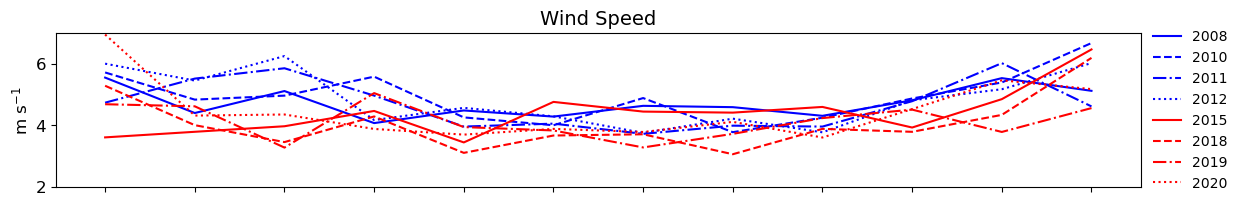

In [49]:
fig, ax = plt.subplots(figsize=(14, 2))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


x=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y1=[None,Feb2007,Mar2007,Apr2007,May2007,Jun2007,Jul2007,Aug2007,Sep2007,Oct2007,Nov2007,Dec2007]
y2=[Jan2008,Feb2008,Mar2008,Apr2008,May2008,Jun2008,Jul2008,Aug2008,Sep2008,Oct2008,Nov2008,Dec2008]
y3=[Jan2009,Feb2009,Mar2009,Apr2009,May2009,Jun2009,Jul2009,Aug2009,Sep2009,Oct2009,Nov2009,Dec2009]
y4=[Jan2010,Feb2010,Mar2010,Apr2010,May2010,Jun2010,Jul2010,Aug2010,Sep2010,Oct2010,Nov2010,Dec2010]
y5=[Jan2011,Feb2011,Mar2011,Apr2011,May2011,Jun2011,Jul2011,Aug2011,Sep2011,Oct2011,Nov2011,Dec2011]
y6=[Jan2012,Feb2012,Mar2012,Apr2012,May2012,Jun2012,Jul2012,Aug2012,Sep2012,Oct2012,Nov2012,Dec2012]
y7=[Jan2013,Feb2013,Mar2013,Apr2013,May2013,Jun2013,Jul2013,Aug2013,Sep2013,Oct2013,Nov2013,Dec2013]
y8=[Jan2014,Feb2014,Mar2014,Apr2014,May2014,Jun2014,Jul2014,Aug2014,Sep2014,Oct2014,Nov2014,None]
y9=[Jan2015,Feb2015,Mar2015,Apr2015,May2015,Jun2015,Jul2015,Aug2015,Sep2015,Oct2015,Nov2015,Dec2015]
y10=[Jan2016,Feb2016,Mar2016,Apr2016,May2016,Jun2016,Jul2016,Aug2016,Sep2016,Oct2016,Nov2016,Dec2016]
y11=[Jan2017,Feb2017,Mar2017,Apr2017,May2017,Jun2017,Jul2017,Aug2017,Sep2017,Oct2017,Nov2017,Dec2017]
y12=[Jan2018,Feb2018,Mar2018,Apr2018,May2018,Jun2018,Jul2018,Aug2018,Sep2018,Oct2018,Nov2018,Dec2018]
y13=[Jan2019,Feb2019,Mar2019,Apr2019,May2019,Jun2019,Jul2019,Aug2019,Sep2019,Oct2019,Nov2019,Dec2019]
y14=[Jan2020,Feb2020,Mar2020,Apr2020,May2020,Jun2020,Jul2020,Aug2020,Sep2020,Oct2020,Nov2020,Dec2020]

#ax.plot(x, y1,label='2007')
ax.plot(x, y2,label='2008',color='b',linestyle='-')
#ax.plot(x, y3,label='2009')
ax.plot(x, y4,label='2010',color='b',linestyle='--')
ax.plot(x, y5,label='2011',color='b',linestyle='-.')
ax.plot(x, y6,label='2012',color='b',linestyle=':')
#ax.plot(x, y7,label='2013')
#ax.plot(x, y8,label='2014',linestyle='--'
#ax.plot(x, y9,label='2015',linestyle='--')
#ax.plot(x, y10,label='2016',linestyle='--')
ax.plot(x, y9,label='2015',color='r',linestyle='-')
ax.plot(x, y12,label='2018',color='r',linestyle='--')
ax.plot(x, y13,label='2019',color='r',linestyle='-.')
ax.plot(x, y14,label='2020',color='r',linestyle=':')

ax.set_title('Wind Speed',fontsize=14)
ax.legend(frameon=False,loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(2,7)
ax.set_ylabel('m s$^{-1}$',fontsize=12)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_xticklabels([])

### Select 4 warmest and 4 coldest years; leave NPGO "neutral" years out

In [50]:
Jan_W=(Jan2015+Jan2018+Jan2019+Jan2020)/4
Feb_W=(Feb2015+Feb2018+Feb2019+Jan2020)/4
Mar_W=(Mar2015+Mar2018+Mar2019+Mar2020)/4
Apr_W=(Apr2015+Apr2018+Apr2019+Apr2020)/4
May_W=(May2015+May2018+May2019+May2020)/4
Jun_W=(Jun2015+Jun2018+Jun2019+Jun2020)/4
Jul_W=(Jul2015+Jul2018+Jul2019+Jul2020)/4
Aug_W=(Aug2015+Aug2018+Aug2019+Aug2020)/4
Sep_W=(Sep2015+Sep2018+Sep2019+Sep2020)/4
Oct_W=(Oct2015+Oct2018+Oct2019+Oct2020)/4
Nov_W=(Nov2015+Nov2018+Nov2019+Nov2020)/4
Dec_W=(Dec2015+Dec2018+Dec2019+Dec2020)/4

In [51]:
Jan_C=(Jan2008+Jan2010+Jan2011+Jan2012)/4
Feb_C=(Feb2008+Feb2010+Feb2011+Jan2012)/4
Mar_C=(Mar2008+Mar2010+Mar2011+Mar2012)/4
Apr_C=(Apr2008+Apr2010+Apr2011+Apr2012)/4
May_C=(May2008+May2010+May2011+May2012)/4
Jun_C=(Jun2008+Jun2010+Jun2011+Jun2012)/4
Jul_C=(Jul2008+Jul2010+Jul2011+Jul2012)/4
Aug_C=(Aug2008+Aug2010+Aug2011+Aug2012)/4
Sep_C=(Sep2008+Sep2010+Sep2011+Sep2012)/4
Oct_C=(Oct2008+Oct2010+Oct2011+Oct2012)/4
Nov_C=(Nov2008+Nov2010+Nov2011+Nov2012)/4
Dec_C=(Dec2008+Dec2010+Dec2011+Dec2012)/4

### Assign years so that SEM can be calculated

In [52]:
Jan_W_years=(Jan2015,Jan2018,Jan2019,Jan2020)
Feb_W_years=(Feb2015,Feb2018,Feb2019,Jan2020)
Mar_W_years=(Mar2015,Mar2018,Mar2019,Mar2020)
Apr_W_years=(Apr2015,Apr2018,Apr2019,Apr2020)
May_W_years=(May2015,May2018,May2019,May2020)
Jun_W_years=(Jun2015,Jun2018,Jun2019,Jun2020)
Jul_W_years=(Jul2015,Jul2018,Jul2019,Jul2020)
Aug_W_years=(Aug2015,Aug2018,Aug2019,Aug2020)
Sep_W_years=(Sep2015,Sep2018,Sep2019,Sep2020)
Oct_W_years=(Oct2015,Oct2018,Oct2019,Oct2020)
Nov_W_years=(Nov2015,Nov2018,Nov2019,Nov2020)
Dec_W_years=(Dec2015,Dec2018,Dec2019,Dec2020)

In [53]:
Jan_C_years=(Jan2008,Jan2010,Jan2011,Jan2012)
Feb_C_years=(Feb2008,Feb2010,Feb2011,Jan2012)
Mar_C_years=(Mar2008,Mar2010,Mar2011,Mar2012)
Apr_C_years=(Apr2008,Apr2010,Apr2011,Apr2012)
May_C_years=(May2008,May2010,May2011,May2012)
Jun_C_years=(Jun2008,Jun2010,Jun2011,Jun2012)
Jul_C_years=(Jul2008,Jul2010,Jul2011,Jul2012)
Aug_C_years=(Aug2008,Aug2010,Aug2011,Aug2012)
Sep_C_years=(Sep2008,Sep2010,Sep2011,Sep2012)
Oct_C_years=(Oct2008,Oct2010,Oct2011,Oct2012)
Nov_C_years=(Nov2008,Nov2010,Nov2011,Nov2012)
Dec_C_years=(Dec2008,Dec2010,Dec2011,Dec2012)

Text(-0.4, 6, '(e)')

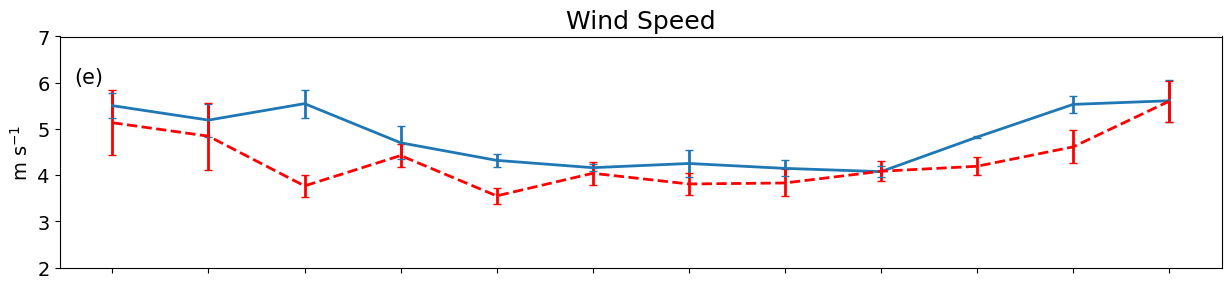

In [54]:
## Preliminary Figure 4e

fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]

x=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y=[Jan_C,Feb_C,Mar_C,Apr_C,May_C,Jun_C,Jul_C,Aug_C,Sep_C,Oct_C,Nov_C,Dec_C]
y2=[Jan_W,Feb_W,Mar_W,Apr_W,May_W,Jun_W,Jul_W,Aug_W,Sep_W,Oct_W,Nov_W,Dec_W]
err1=[sem(Jan_C_years),sem(Feb_C_years),sem(Mar_C_years),sem(Apr_C_years),sem(May_C_years),sem(Jun_C_years),\
     sem(Jul_C_years),sem(Aug_C_years),sem(Sep_C_years),sem(Oct_C_years),sem(Nov_C_years),sem(Dec_C_years)]
err2=[sem(Jan_W_years),sem(Feb_W_years),sem(Mar_W_years),sem(Apr_W_years),sem(May_W_years),sem(Jun_W_years),\
     sem(Jul_W_years),sem(Aug_W_years),sem(Sep_W_years),sem(Oct_W_years),sem(Nov_W_years),sem(Dec_W_years)]

ax.errorbar(x, y, yerr= err1, capsize=3,label='NPGO+ coldest',linewidth=2)
ax.errorbar(x, y2,yerr= err2, capsize=3,linestyle='--',label='NPGO- warmest',color='r',linewidth=2)

ax.set_title('Wind Speed',fontsize=18)  #(with 2015)
ax.legend((),frameon=False)
ax.set_ylim(2,7)
ax.set_ylabel('m s$^{-1}$',fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xticklabels([])

a=2
b=5
c=5
d=8
#plt.fill([a, a, b, b], [0, 200, 200, 0], color = 'lightgreen', alpha = 0.1)
#plt.fill([c, c, d, d], [0, 200, 200, 0], color = 'wheat', alpha = 0.2)
ax.text(-.4, 6, '(e)', fontsize=15,  color='k')

#plt.savefig('Fig3e_Wind.png', bbox_inches='tight',dpi=1000,transparent=False)

### Data for Figure 4: Calculate monthly standard error values for cold and warm years

In [55]:
print(Jan_C,Feb_C,Mar_C,Apr_C,May_C,Jun_C,Jul_C,Aug_C,Sep_C,Oct_C,Nov_C,Dec_C)

5.503117561340332 5.190681457519531 5.546851634979248 4.699765205383301 4.319005012512207 4.160552978515625 4.251698970794678 4.14553689956665 4.074483394622803 4.822423458099365 5.530994415283203 5.60904598236084


In [56]:
print(Jan_W,Feb_W,Mar_W,Apr_W,May_W,Jun_W,Jul_W,Aug_W,Sep_W,Oct_W,Nov_W,Dec_W)

5.133814334869385 4.842380046844482 3.766061544418335 4.423320770263672 3.550428867340088 4.039124488830566 3.807666540145874 3.829700469970703 4.08309268951416 4.191368103027344 4.611095428466797 5.599612236022949


In [57]:
print(sem(Jan_C_years),sem(Feb_C_years),sem(Mar_C_years),sem(Apr_C_years),sem(May_C_years),sem(Jun_C_years),\
     sem(Jul_C_years),sem(Aug_C_years),sem(Sep_C_years),sem(Oct_C_years),sem(Nov_C_years),sem(Dec_C_years))

0.2716546654701233 0.3555466830730438 0.3046501874923706 0.3556775450706482 0.13578826189041138 0.07550367712974548 0.2988617420196533 0.17373867332935333 0.12545664608478546 0.018483856692910194 0.17944231629371643 0.45889315009117126


In [58]:
print(sem(Jan_W_years),sem(Feb_W_years),sem(Mar_W_years),sem(Apr_W_years),sem(May_W_years),sem(Jun_W_years),\
     sem(Jul_W_years),sem(Aug_W_years),sem(Sep_W_years),sem(Oct_W_years),sem(Nov_W_years),sem(Dec_W_years))

0.6975691318511963 0.7239692807197571 0.24488499760627747 0.2416556030511856 0.17904892563819885 0.24562996625900269 0.24054600298404694 0.2916531264781952 0.2151043862104416 0.1926278918981552 0.35777175426483154 0.44312936067581177


In [59]:
from scipy import stats

# Initialise a list of combinations of groups that are significantly different
significant_combinations = []
# Check from the outside pairs of boxes inwards
ls = list(range(1, len(data) + 1))
combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
for combination in combinations:
    data1 = data[combination[0] - 1]
    data2 = data[combination[1] - 1]
    # Significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    if p < 0.05:
        significant_combinations.append([combination, p])

NameError: name 'data' is not defined

In [ ]:
## Preliminary Figure 4e

def color_boxplot(data, color, pos=[0], ax=None):
    ax = ax or plt.gca()
    bp = ax.boxplot(data, patch_artist=True,  showmeans=False, positions=pos,widths=0.4)
    for item in ['boxes']:
        plt.setp(bp[item], color=color)
    for item in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[item], color='k')


data1 = [Mar_C,Apr_C,May_C]
data2 = [Mar_W,Apr_W,May_W]
data3 = [Jun_C,Jul_C,Aug_C]
data4 = [Jun_W,Jul_W,Aug_W]

fig, ax = plt.subplots(figsize=(3,3))
bp1 = color_boxplot(data1, 'royalblue', [1])
bp2 = color_boxplot(data2, 'r', [1.5])
bp3 = color_boxplot(data3, 'royalblue', [2.5])
bp4 = color_boxplot(data4, 'r', [3])
#ax.autoscale()
ax.set(xticks=[1.25,2.75], xticklabels=['Spring','Summer'])
ax.set_ylim(2,6)
ax.set_ylabel('m s$^{-1}$')


5.65, 5.75, 5.75, 5.65

## To indicate significance
plt.plot([1,1, 1.5, 1.5], [5.65, 5.75, 5.75, 5.65], linewidth=1, color='k')
ax.text(1.25, 5.74, "NS", ha='center', va='bottom', color=col,fontsize=9)

plt.plot([2.5,2.5, 3, 3], [4.4, 4.5, 4.5, 4.4], linewidth=1, color='k')
ax.text(2.75, 4.5, "*", ha='center', va='bottom', color=col,fontsize=12)

#ax.legend([bp1["boxes"], bp2["boxes"], ['A', 'B'], loc='upper right')
plt.show()

In [ ]:
Spring_C=[Mar_C,Apr_C,May_C]

In [ ]:
Spring_W=[Mar_W,Apr_W,May_W]

In [ ]:
Summer_C=[Jun_C,Jul_C,Aug_C]

In [ ]:
Summer_W=[Jun_W,Jul_W,Aug_W]

In [ ]:
Spring_C

In [ ]:
Spring_W

In [ ]:
Summer_C

In [ ]:
Summer_W

### t tests for differences between spring and summer of cold and warm years

In [ ]:
stats.ttest_ind(a=Spring_C, b=Spring_W, equal_var=True)

In [ ]:
stats.ttest_ind(a=Summer_C, b=Summer_W, equal_var=True)